# Handling and Visualizing Data

In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import colorcet as cc
from bokeh.transform import linear_cmap, factor_cmap
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.palettes import Spectral11
from bokeh.models.sources import ColumnDataSource
import networkx as nx
from networkx.algorithms import bipartite

import preprocessing
import topic_modeling

In [2]:
folder_path = os.path.abspath('MovieSummaries')
df_movies, df_summaries = preprocessing.get_datasets(folderpath=folder_path)


In [3]:
df_genres = preprocessing.get_movie_genres_dataframe(df_movies=df_movies)
df_fictional_summaries, df_fictional = preprocessing.get_fictional_summaries_subset(df_genres=df_genres, df_movies=df_movies, df_summaries=df_summaries, return_df_fictional=True)

   Wikipedia_movie_ID Freebase_genre_ID      movie_genre  release_year
0              975900         /m/01jfsb         Thriller        2001.0
1              975900          /m/06n90  Science Fiction        2001.0
2              975900          /m/03npn           Horror        2001.0
3              975900         /m/03k9fj        Adventure        2001.0
4              975900          /m/0fdjb     Supernatural        2001.0
The total number of movies referred to as fictional is 5366, corresponding to 6.56% of whole movies.


In [12]:
#display(df_fictional)
display(df_genres[df_genres["movie_genre"]=='Science fiction'])

,Wikipedia_movie_ID,Freebase_genre_ID,movie_genre,release_year


## Movie Genres

In [4]:
df_genres_wo_Nan = df_genres.dropna(axis=0)

In [5]:
#Keeping only the n more represented genres
n=20
main_genres = df_genres_wo_Nan.groupby("movie_genre").count().sort_values("Wikipedia_movie_ID",ascending=False).reset_index()
main_genres = main_genres["movie_genre"].values[:n]

df_main_genres = df_genres_wo_Nan.loc[df_genres_wo_Nan["movie_genre"].isin(main_genres)]
df_main_genres['release_year'] = df_main_genres['release_year'].astype(int)
#propotion of movies regarding the total number of movies released during the year
year_releases = df_genres_wo_Nan.groupby("release_year")["Wikipedia_movie_ID"].count().to_frame().reset_index().rename(columns={"Wikipedia_movie_ID":"number of movies"})
display(df_main_genres)



C:\Users\aubru\AppData\Local\Temp\ipykernel_29988\4122994911.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main_genres['release_year'] = df_main_genres['release_year'].astype(int)


,Wikipedia_movie_ID,Freebase_genre_ID,movie_genre,release_year
0,975900,/m/01jfsb,Thriller,2001
2,975900,/m/03npn,Horror,2001
3,975900,/m/03k9fj,Adventure,2001
5,975900,/m/02kdv5l,Action,2001
7,3196793,/m/02n4kr,Mystery,2000
...,...,...,...,...
243320,913762,/m/03k9fj,Adventure,1992
243322,913762,/m/02hmvc,Short Film,1992
243324,913762,/m/07s9rl0,Drama,1992
243325,12476867,/m/01jfsb,Thriller,2002


In [6]:
#Transform the relational table for the stack plot 

genres = df_main_genres['movie_genre'].unique().tolist()
years = df_main_genres['release_year'].sort_values().unique().tolist()

# Initialize dictionary to store the desired format
result_dict = {'years': years}

# Populate the dictionary with counts
for genre in genres:
    genre_counts = []
    for year in years:
        count = df_main_genres[(df_main_genres['movie_genre'] == genre) & (df_main_genres['release_year'] == year)].shape[0]
        genre_counts.append(count)
    result_dict[genre] = genre_counts

# Convert the result_dict to DataFrame
result_df = pd.DataFrame(result_dict)
#result_df = result_df.set_index("years",drop=True)
result_df["number_of_movies"] = df_main_genres.drop_duplicates("Wikipedia_movie_ID").groupby("release_year")['release_year'].count().values
result_df["total_number_of_movies"] = df_movies.groupby("release_year")['release_year'].count().values

# Print or use the result_df as needed
display(result_df)

,years,Thriller,Horror,Adventure,Action,Mystery,Drama,Crime Fiction,Short Film,Silent film,...,Family Film,World cinema,Musical,Action/Adventure,Romantic drama,Romance Film,Comedy film,Documentary,number_of_movies,total_number_of_movies
0,1888,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,1
1,1889,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,1
2,1890,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,2,2
3,1891,0,0,0,0,0,0,0,3,1,...,0,0,0,0,0,0,0,0,3,3
4,1892,0,0,0,0,0,0,0,3,3,...,0,0,0,0,0,0,0,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2012,172,100,58,187,38,427,60,38,3,...,46,4,26,12,4,172,219,75,1039,1194
125,2013,41,11,26,44,3,45,17,1,0,...,16,0,2,1,0,13,22,3,141,164
126,2014,1,0,5,1,0,4,0,0,0,...,1,0,0,0,0,3,1,0,11,17
127,2015,0,0,1,2,0,0,1,0,0,...,0,0,0,0,0,0,1,0,3,4


In [7]:
#Interractive Stacked plot 

p = figure(width=1200, height=800,x_range=(min(result_df["years"].tolist()),max(result_df["years"].tolist())), y_range=(-5000, 10000))

p.grid.minor_grid_line_color = '#eeeeee'
palette = cc.glasbey_dark[:len(genres)]
p.varea_stack(stackers=genres, x='years',legend_label=genres,source=result_df, fill_color=palette)

# Create a ColumnDataSource
source = ColumnDataSource(data=dict(
    years=result_df["years"].tolist(),
    total_number_of_movies=-result_df["total_number_of_movies"].values,
    number_of_movies=-result_df["number_of_movies"].values,
    missing_movies=result_df["number_of_movies"].values - result_df["total_number_of_movies"].values,
    ratio =(result_df["number_of_movies"].values/result_df["total_number_of_movies"].values)*100))

# Plot the varea using the ColumnDataSource
varea = p.varea(x='years', y1='total_number_of_movies', y2='number_of_movies', color='black', legend_label='Missing movies with current genres selection', source=source)

# Add a HoverTool
hover = HoverTool(renderers=[varea],
                  tooltips=[("Years", "@years"),
                            ("Missing movies", "@missing_movies"),
                            ("Ratio (%)","@ratio")],)

p.add_tools(hover)

#p.line(result_df["years"].tolist(),-result_df["number_of_movies"].values,line_width=2,legend_label="Number of movies of the selected genres",color="red")
#p.line(result_df["years"].tolist(),-result_df["total_number_of_movies"].values,line_width=2,legend_label="Total_number of movies",color="black")
#p.varea(result_df["years"].tolist(),-result_df["total_number_of_movies"].values,-result_df["number_of_movies"].values, color='black',legend_label='Missing movies with current genres selection')
p.legend.location = "top_left"
p.legend.nrows = len(genres)//2+1
p.legend.ncols=2
p.legend.click_policy="mute"


show(p)

Index([1888.0, 1889.0, 1890.0, 1891.0, 1892.0, 1893.0, 1894.0, 1895.0, 1896.0,
       1897.0,
       ...
       2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0,
          nan],
      dtype='float64', name='years', length=130)

C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aubru\anaconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

<Axes: xlabel='release_year', ylabel='Count'>

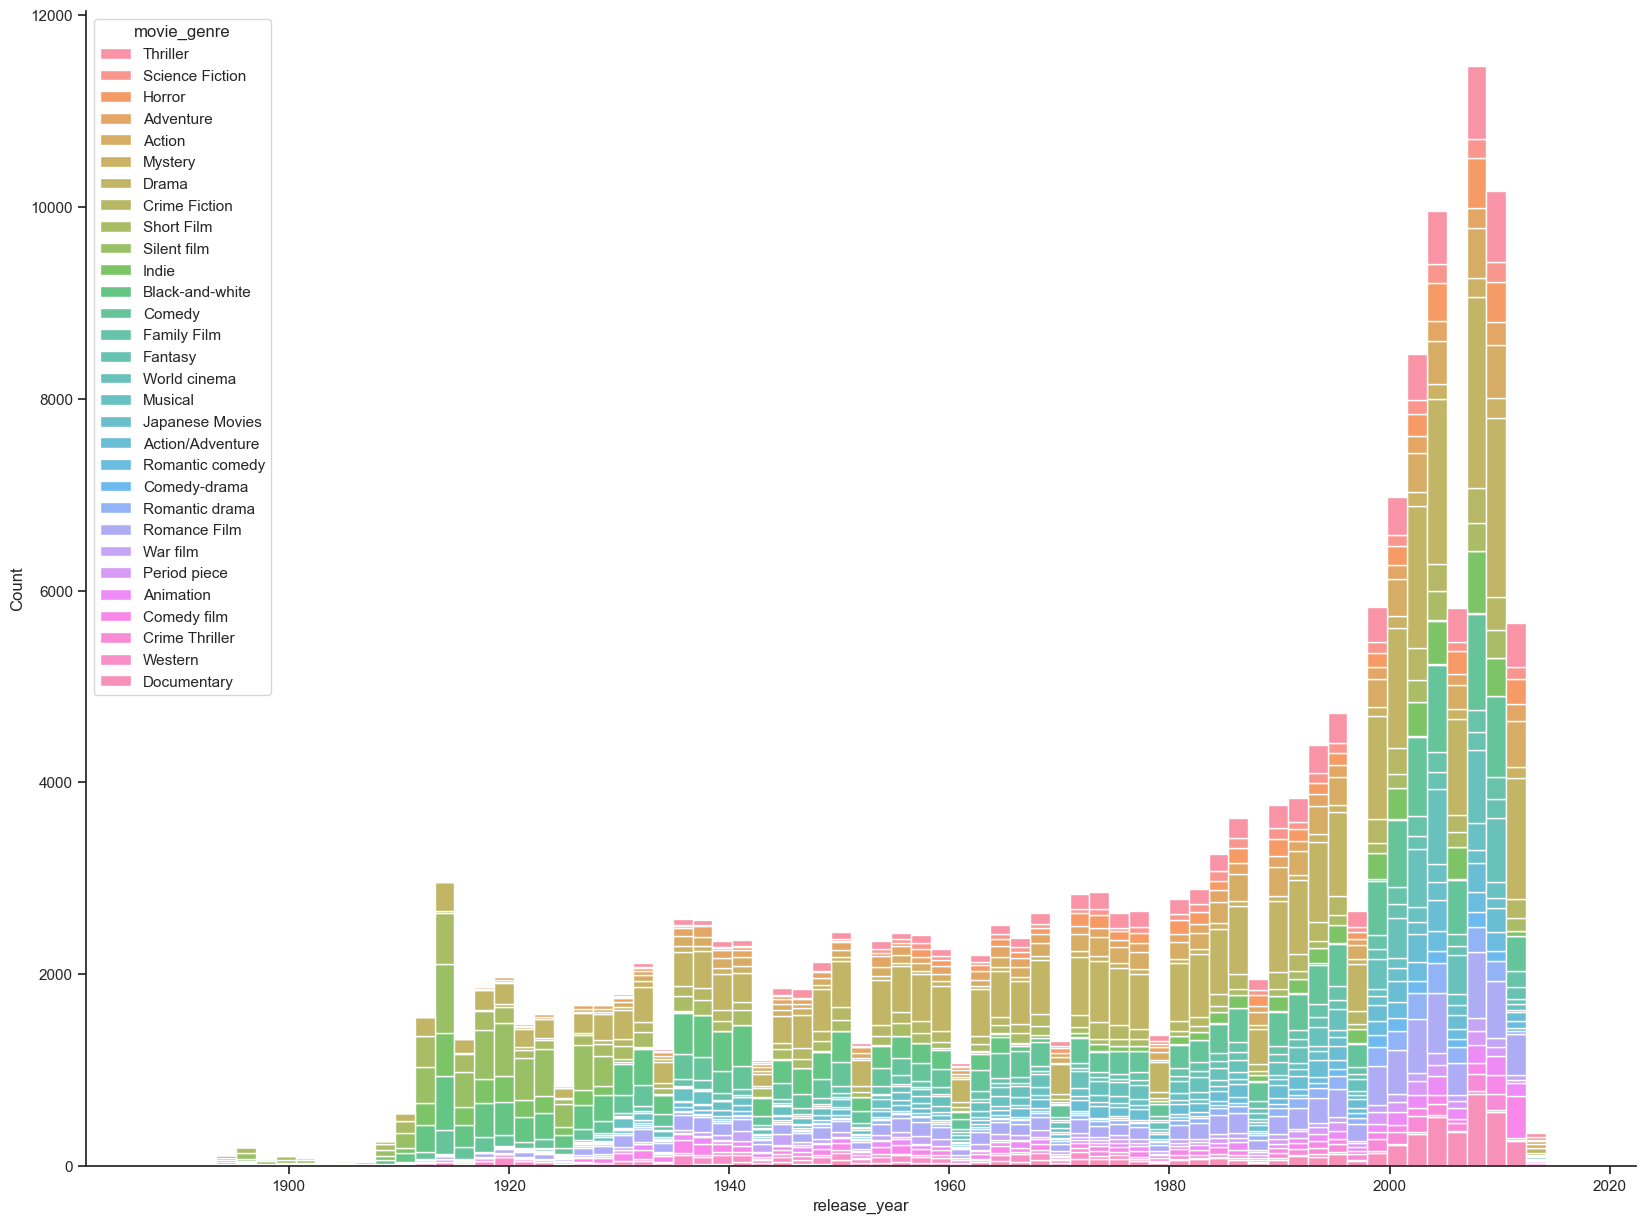

In [9]:


sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(20, 15))
sns.despine(f)

sns.histplot(
    df_main_genres,
    x="release_year", hue="movie_genre",
    multiple="stack",
    )


### Trying to build a bipartite graph to analyse the relations between genres. How close they are from each other

In [20]:
df_genres = df_genres[df_genres["movie_genre"]!='Romantic thriller']
Wikipedia_movie_ID = df_genres["Wikipedia_movie_ID"].unique().tolist()
Genres = df_genres["movie_genre"].unique().tolist()
Edges_WmovieID_Genres = df_genres[["Wikipedia_movie_ID","movie_genre"]].values.tolist()

,Wikipedia_movie_ID,Freebase_genre_ID,movie_genre
0,975900,/m/01jfsb,Thriller
1,975900,/m/06n90,Science Fiction
2,975900,/m/03npn,Horror
3,975900,/m/03k9fj,Adventure
5,975900,/m/02kdv5l,Action
...,...,...,...
243321,913762,/m/0hcr,Animation
243322,913762,/m/02hmvc,Short Film
243324,913762,/m/07s9rl0,Drama
243325,12476867,/m/01jfsb,Thriller


In [50]:
B = nx.Graph()
B.add_nodes_from(df_main_genres["Wikipedia_movie_ID"], bipartite=0)
B.add_nodes_from(df_main_genres["movie_genre"], bipartite=1)
B.add_edges_from([(row['Wikipedia_movie_ID'],row['movie_genre']) for idx, row in df_main_genres.iterrows()])



In [82]:
top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(B) - top_nodes

G = bipartite.weighted_projected_graph(B, bottom_nodes)

#d = dict(G.degree)
dx,dy= bipartite.degrees(B,nodes=top_nodes)
d=dict(dx)
print(d)

{'War film': 2652, 'Romantic drama': 3372, 'Romance Film': 10234, 'Mystery': 3195, 'Crime Thriller': 2122, 'Indie': 6897, 'Silent film': 5250, 'Family Film': 4598, 'Black-and-white': 9094, 'Thriller': 8744, 'Adventure': 4963, 'Comedy': 16349, 'Fantasy': 2820, 'Documentary': 5630, 'Drama': 34007, 'Action': 8798, 'World cinema': 7155, 'Horror': 5280, 'Science Fiction': 3052, 'Animation': 3534, 'Crime Fiction': 6948, 'Western': 2225, 'Musical': 4160, 'Romantic comedy': 2680, 'Comedy film': 4362, 'Period piece': 1758, 'Comedy-drama': 1720, 'Action/Adventure': 4561, 'Short Film': 8141, 'Japanese Movies': 2322}


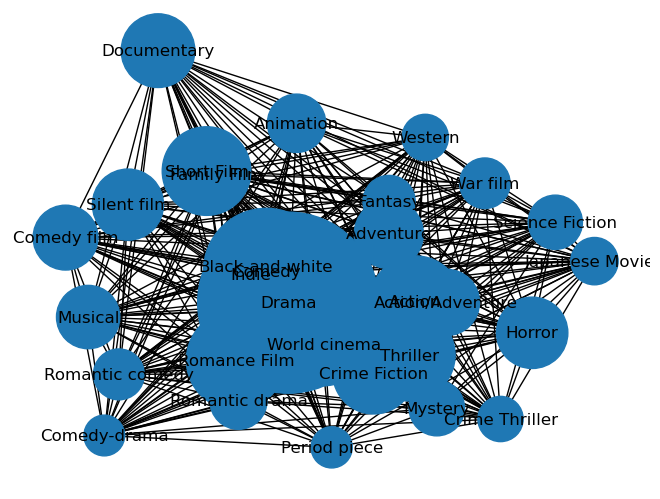

True

In [103]:
nx.draw(G,nodelist=d.keys(),with_labels=1,node_size=[v/2 for v in d.values()])

plt.show()
nx.is_connected(G)